In [1]:
import joblib
import sys
import pathlib
import yaml
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

2025-05-05 12:55:11.178847: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 12:55:11.187637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746471311.196838 2857438 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746471311.199601 2857438 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746471311.207528 2857438 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Metadata Column Definition

In [2]:
CELL_TYPE_COL = 'encode_celltype'
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
TECH_COL = 'samp_type'
DATASPLIT_COL = 'isTraining'

GENE_ID_COL = 'gene_ids'

## Obtain repository root directory for access to preprocessed data, config file and local package

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

### Import packages

In [4]:
buddi_fork_path = config_dict['software_path']['buddi_v2']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.append(str(REPO_ROOT))
sys.path.append(str(buddi_fork_path))
# this is quite ugly, once activate modifications are done this will be changed
# to a proper installation + import
from analysis_utils.buddi4data import BuDDI4Data
from buddi_v2.dataset.buddi4_dataset import get_supervised_dataset, get_unsupervised_dataset
from buddi_v2.models.buddi4 import fit_buddi4
from buddi_v2.models.components.losses import unsupervised_dummy_loss_fn
from buddi_v2.models.buddi4_class import BuDDI4
from buddi_v2.plotting.plot_latent_space import plot_latent_spaces_buddi4
from buddi_v2.plotting.plot_data import plot_data

I0000 00:00:1746471312.135058 2857438 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4606 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


## Define paths to Input Files/Output

### Input from pre-processing

In [5]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data' 
train_data_file = PREPROCESSING_OUTPUT_PATH / 'buddi4_train_data.pkl'
assert train_data_file.exists(), f"Train data file not found at {train_data_file}"

### Trained model save path

In [6]:
TRAINED_MODELS_PATH = REPO_ROOT / 'trained'
model_folders = sorted(TRAINED_MODELS_PATH.glob('buddi4_*'))
assert len(model_folders) > 0, f"No trained models found in {TRAINED_MODELS_PATH}"

In [7]:
model_folders

[PosixPath('/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=10.0_beta=10.0'),
 PosixPath('/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=100.0_beta=10.0_beta_slack=1000.0'),
 PosixPath('/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=100.0_beta=100.0'),
 PosixPath('/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=100.0_beta=100.0_beta_slack=0.1')]

## Load Data

In [8]:
train_data = joblib.load(train_data_file)
print(train_data)
print('\n')

n_x = len(train_data.gene_names)
n_y = len(train_data.cell_type_names)
n_labels = train_data.encode_meta[SAMPLE_ID_COL].shape[1]
n_stims = train_data.encode_meta[STIM_COL].shape[1]
n_samp_types = train_data.encode_meta[TECH_COL].shape[1]
print(f"Number of genes: {n_x}")
print(f"Number of cell types: {n_y}")
print(f"Number of unique labels: {n_labels}")
print(f"Number of unique stimulations: {n_stims}")
print(f"Number of unique sample types: {n_samp_types}")

BuDDIData(unkp_samples=588, kp_samples=8400, genes=7000, cell_types=11)


Number of genes: 7000
Number of cell types: 11
Number of unique labels: 593
Number of unique stimulations: 2
Number of unique sample types: 2


## Load Trained model

In [ ]:
obj = BuDDI4.load(
    REPO_ROOT / 'trained' / 'buddi4_alpha=100.0_beta=10.0_beta_label=1.0_beta_slack=0.1',
)

In [ ]:
# obj = BuDDI4.load(
#     '/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=100.0_beta=100.0_beta_slack=0.1'
# )

In [10]:
print(obj.encoders)
print(obj.decoder)
print(obj.prop_estimator)

{'label': <Functional name=encoder_label, built=True>, 'stim': <Functional name=encoder_stim, built=True>, 'samp_type': <Functional name=encoder_samp_type, built=True>, 'slack': <Functional name=encoder_slack, built=True>}
<Functional name=shared_X_decoder, built=True>
<Functional name=prop_estimator, built=True>


In [11]:
from analysis_utils.validation.perturb_cell_type import perturb_cell_type
from sklearn.decomposition import PCA
import pandas as pd

In [12]:
x_perturb, meta_perturb = perturb_cell_type(
    obj=obj,
    data=train_data,
    cell_type_col='cell_type',
    idx=None,
    n_subsamples=500,
    seed=42,
)

Perturb CT: 100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


In [13]:
x_perturb.shape

(55000, 7000)

In [14]:
meta_perturb.head()

,sample_id,stim,samp_type,isTraining,cell_prop_type,cell_type,reconstruction_type,perturb_type,source,target
0,Samp-T76,white,sc_ref,Train,single_celltype,Adipocytes,perturbed,cell_type,Adipocytes,B-cells
1,Samp-T90,white,sc_ref,Train,single_celltype,Adipocytes,perturbed,cell_type,Adipocytes,B-cells
2,Samp-T76,white,sc_ref,Train,single_celltype,Adipocytes,perturbed,cell_type,Adipocytes,B-cells
3,Samp-T89,white,sc_ref,Train,single_celltype,Adipocytes,perturbed,cell_type,Adipocytes,B-cells
4,Samp-T77,white,sc_ref,Train,single_celltype,Adipocytes,perturbed,cell_type,Adipocytes,B-cells


In [15]:
from analysis_utils.validation.resample import reconstruct

In [16]:
x_reconstruct, meta_reconstruct = reconstruct(
    obj=obj,
    data=train_data,
    idx=None,
    n_resamples=1,
    seed=42,
)

In [17]:
x_reconstruct.shape

(8400, 7000)

In [18]:
meta_reconstruct.head()

,sample_id,stim,samp_type,isTraining,cell_prop_type,cell_type,reconstruction_type,perturb_type,source,target
0,Samp-T77,white,sc_ref,Train,random,random,reconstruction,unperturbed,None,None
1,Samp-T77,white,sc_ref,Train,random,random,reconstruction,unperturbed,None,None
2,Samp-T77,white,sc_ref,Train,random,random,reconstruction,unperturbed,None,None
3,Samp-T76,white,sc_ref,Train,single_celltype,Fibroblasts,reconstruction,unperturbed,None,None
4,Samp-T77,white,sc_ref,Train,single_celltype,Macrophages,reconstruction,unperturbed,None,None


In [19]:
# meta_reconstruct['source'] = meta_reconstruct['cell_type'].astype('str')
# meta_reconstruct['target'] = meta_reconstruct['cell_type'].astype('str')

# _meta = meta_reconstruct.loc[:,['source', 'target']].copy()
# _meta_perturb = pd.DataFrame(
#     data = {
#         'source': [src] * len(recon),
#         'target': [tgt] * len(recon)
#     }
# )

# pca = PCA(n_components=2)
# proj_pca = pca.fit_transform(
#     np.concatenate([x_reconstruct, recon], axis=0)
# )
# proj_df = pd.DataFrame(
#             data=proj_pca,
#             columns=['PCA1', 'PCA2']
#         )

# proj_df = pd.concat([
#     proj_df,
#     pd.concat([
#         _meta,
#         _meta_perturb
#     ], axis=0).reset_index(drop=True, inplace=False)
# ], axis=1)

# fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(24, 8),
#         sharex=True, sharey=True,)  # <— shared axes)

# proj_name = 'PCA'
# sns.scatterplot(
#     data=proj_df,
#     x=proj_name + '1',
#     y=proj_name + '2',
#     hue='source',
#     size=0.1,
#     ax=ax[0],
#     alpha=1.0,
#     palette='tab20'
# )
# sns.scatterplot(
#     data=proj_df,
#     x=proj_name + '1',
#     y=proj_name + '2',
#     hue='target',
#     size=0.1,
#     ax=ax[1],
#     alpha=1.0,
#     palette='tab20'
# )
# sns.scatterplot(
#     data=proj_df.iloc[np.where(proj_df['source'] != proj_df['target'])[0], :],
#     x=proj_name + '1',
#     y=proj_name + '2',
#     hue='target',
#     size=0.1,
#     ax=ax[2],
#     alpha=1.0,
#     palette='tab20'
# )

Encoding branch: label
Encoding branch: stim
Encoding branch: samp_type
Encoding branch: slack
Valid cell types: ['Adipocytes', 'B-cells', 'CD4+ T-cells', 'CD8+ T-cells', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'Macrophages', 'Mesangial cells', 'Monocytes', 'NK cells']


<Axes: xlabel='PCA1', ylabel='PCA2'>

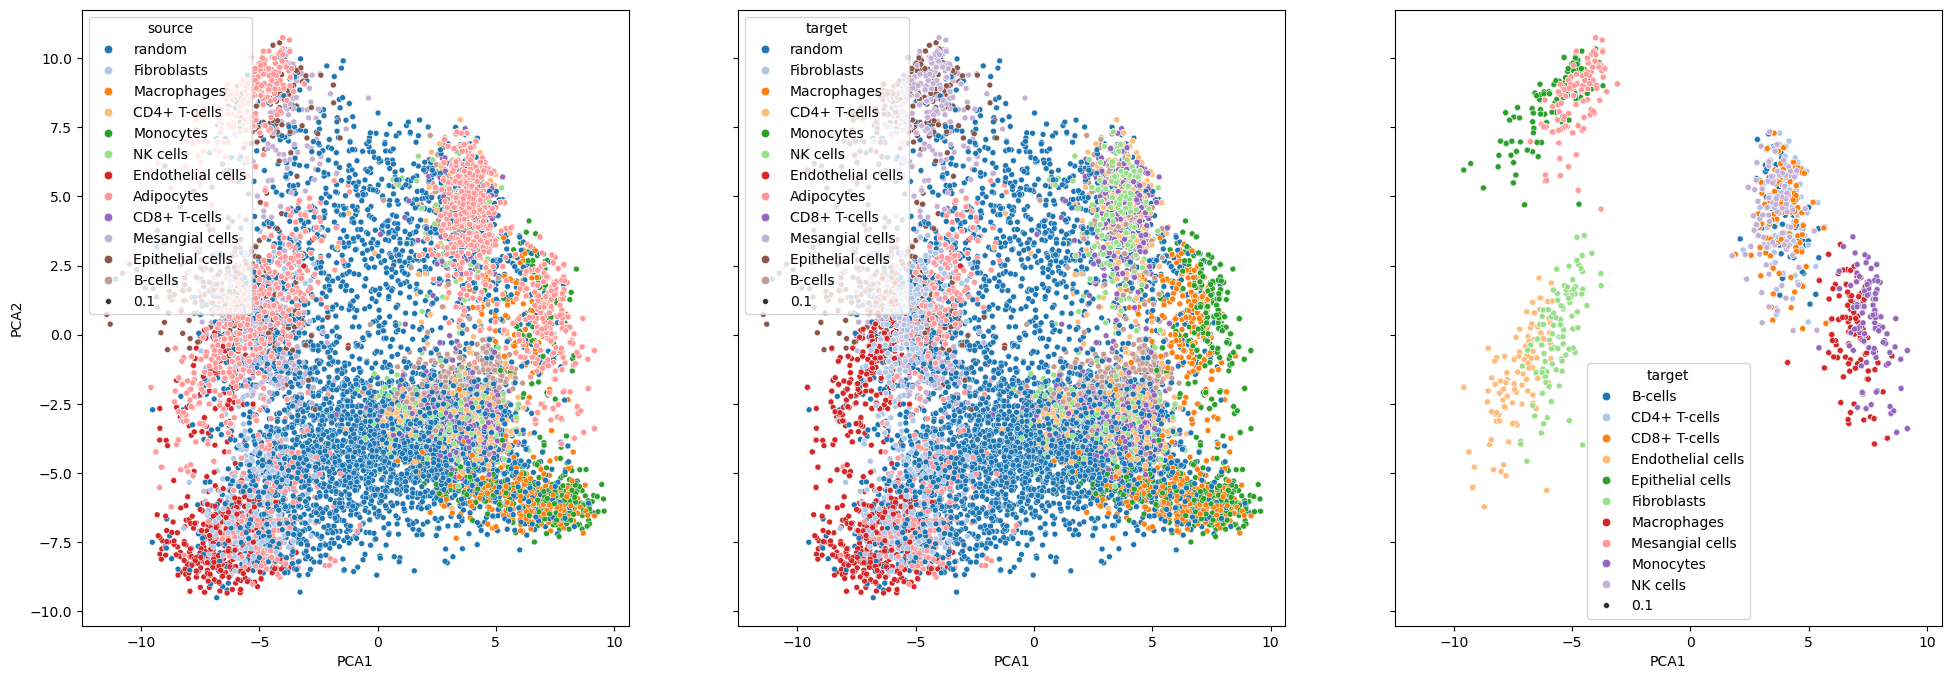

In [19]:
X = train_data.get('kp', 'X')
y = train_data.get('kp', 'Y')
meta = train_data.get('kp', 'meta')
idx = np.where(meta['sample_id'] == 'Samp-T77')[0]
X = X[idx, :]
y = y[idx, :]
meta = meta.iloc[idx, :].copy()

zs = []
branch_names = list(obj.encoder_branch_names)
if 'slack' in obj.encoders:
    branch_names += ['slack']
for i, branch in enumerate(branch_names):
    print(f"Encoding branch: {branch}")
    zp = obj.encoders[branch](X)
    zs.append(obj.reparam_layers[branch](zp).numpy())

ct_to_idx = {ct: np.where(meta['cell_type'] == ct)[0]
                 for ct in train_data.cell_type_names}

valid_ct = [ct for ct, rows in ct_to_idx.items() if rows.size > 0]
print(f"Valid cell types: {valid_ct}")

rng = np.random.default_rng(42)
src = 'Adipocytes'
n_subsamples = 500
x_perts = []
meta_perts = []
for i, tgt in enumerate(train_data.cell_type_names):
    src_rows = ct_to_idx[src]
    #tgt_rows = ct_to_idx[tgt]
    pick_src = rng.choice(src_rows, size=n_subsamples, replace=True)
    #pick_tgt = rng.choice(tgt_rows, size=n_subsamples, replace=True)

    zs_src = [
                    z[pick_src,:] for z in zs
                ]
    y_tgt = np.zeros((n_subsamples, len(train_data.cell_type_names)))
    y_tgt[:, i] = 1.0
    
    with tf.device('/CPU:0'):
        recon = obj.decoder([y_tgt] + zs_src).numpy()
    x_perts.append(recon)
    meta_perts.append(
        pd.DataFrame(
            data={
                'source': [src] * len(recon),
                'target': [tgt] * len(recon),
            }
        )
    )

x_pert = np.concatenate(x_perts, axis=0)
meta_pert = pd.concat(meta_perts, axis=0)

meta_reconstruct['source'] = meta_reconstruct['cell_type'].astype('str')
meta_reconstruct['target'] = meta_reconstruct['cell_type'].astype('str')
_meta = meta_reconstruct.loc[:,['source', 'target']].copy()

_meta_perturb = meta_pert.loc[:,['source', 'target']].copy()

pca = PCA(n_components=2)
proj_pca = pca.fit_transform(
    np.concatenate([
        x_reconstruct, 
        x_pert,
        ], axis=0)
)
proj_df = pd.DataFrame(
            data=proj_pca,
            columns=['PCA1', 'PCA2']
        )

proj_df = pd.concat([
    proj_df,
    pd.concat([
        _meta,
        _meta_perturb
    ], axis=0).reset_index(drop=True, inplace=False)
], axis=1)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(24, 8),
        sharex=True, sharey=True,)  # <— shared axes)

proj_name = 'PCA'
sns.scatterplot(
    data=proj_df,
    x=proj_name + '1',
    y=proj_name + '2',
    hue='source',
    size=0.1,
    ax=ax[0],
    alpha=1.0,
    palette='tab20'
)
sns.scatterplot(
    data=proj_df,
    x=proj_name + '1',
    y=proj_name + '2',
    hue='target',
    size=0.1,
    ax=ax[1],
    alpha=1.0,
    palette='tab20'
)
sns.scatterplot(
    data=proj_df.iloc[np.where(proj_df['source'] != proj_df['target'])[0], :],
    x=proj_name + '1',
    y=proj_name + '2',
    hue='target',
    size=0.1,
    ax=ax[2],
    alpha=1.0,
    palette='tab20'
)

<Axes: xlabel='PCA1', ylabel='PCA2'>

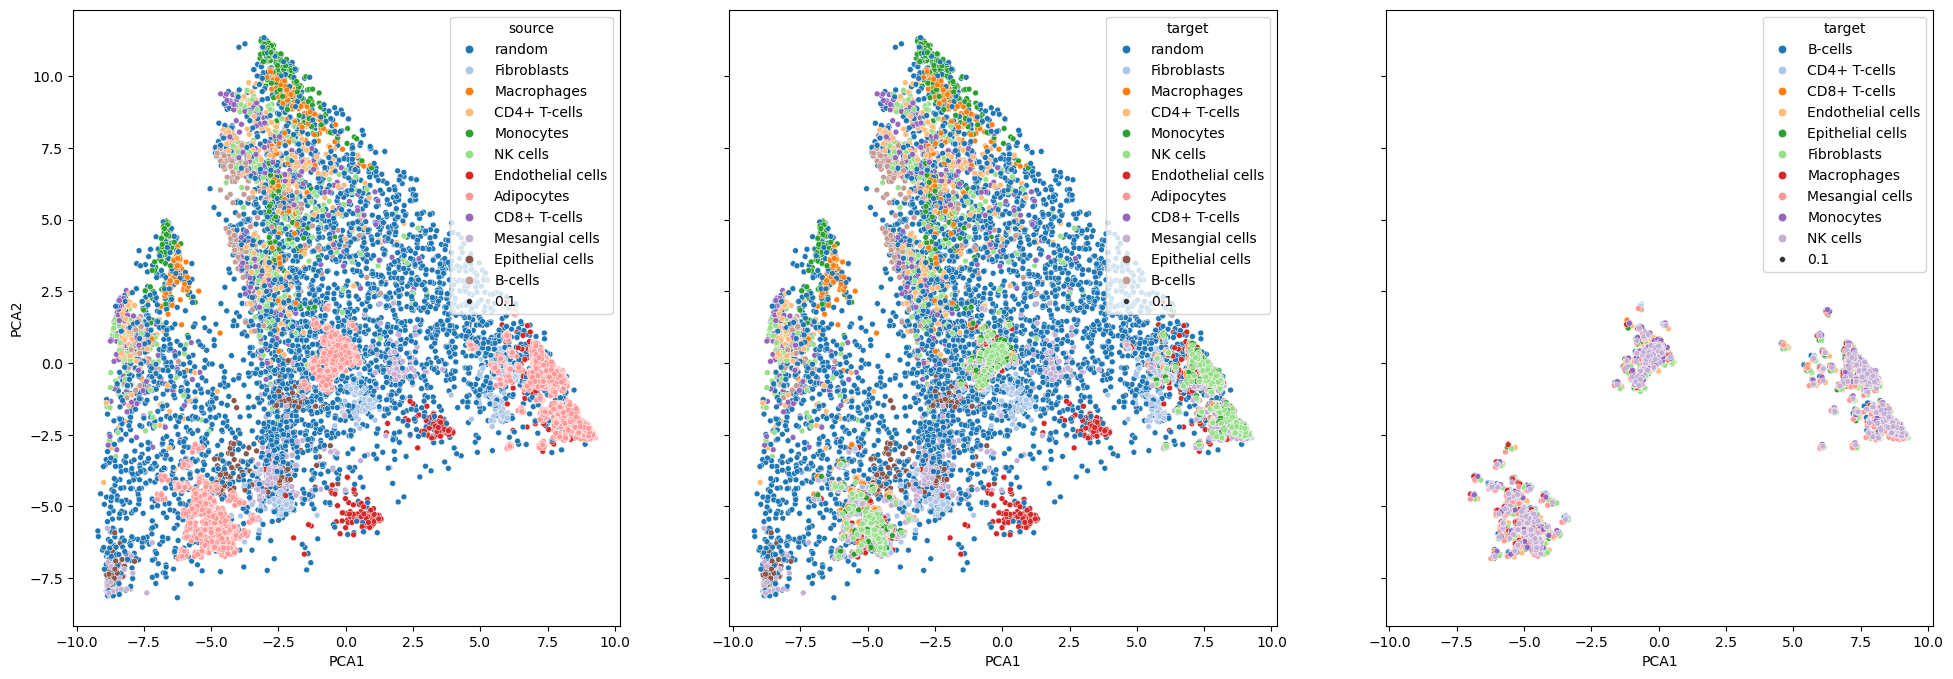

In [21]:
meta_reconstruct['source'] = meta_reconstruct['cell_type'].astype('str')
meta_reconstruct['target'] = meta_reconstruct['cell_type'].astype('str')
_meta = meta_reconstruct.loc[:,['source', 'target']].copy()

adipocyte_idx = np.where(
    meta_perturb['source'] == 'Adipocytes'
)[0]

_meta_perturb = meta_perturb.iloc[adipocyte_idx].loc[:,['source', 'target']].copy()

pca = PCA(n_components=2)
proj_pca = pca.fit_transform(
    np.concatenate([
        x_reconstruct, 
        x_perturb[adipocyte_idx, :],
        ], axis=0)
)
proj_df = pd.DataFrame(
            data=proj_pca,
            columns=['PCA1', 'PCA2']
        )

proj_df = pd.concat([
    proj_df,
    pd.concat([
        _meta,
        _meta_perturb
    ], axis=0).reset_index(drop=True, inplace=False)
], axis=1)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(24, 8),
        sharex=True, sharey=True,)  # <— shared axes)

proj_name = 'PCA'
sns.scatterplot(
    data=proj_df,
    x=proj_name + '1',
    y=proj_name + '2',
    hue='source',
    size=0.1,
    ax=ax[0],
    alpha=1.0,
    palette='tab20'
)
sns.scatterplot(
    data=proj_df,
    x=proj_name + '1',
    y=proj_name + '2',
    hue='target',
    size=0.1,
    ax=ax[1],
    alpha=1.0,
    palette='tab20'
)
sns.scatterplot(
    data=proj_df.iloc[np.where(proj_df['source'] != proj_df['target'])[0], :],
    x=proj_name + '1',
    y=proj_name + '2',
    hue='target',
    size=0.1,
    ax=ax[2],
    alpha=1.0,
    palette='tab20'
)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from typing import Optional, Iterable, List, Tuple

def plot_perturb_pca(
    x_basis: np.ndarray,
    meta_basis: pd.DataFrame,
    x_perturb: np.ndarray,
    meta_perturb: pd.DataFrame,
    filter_source: Optional[str] = None,
    filter_target: Optional[str] = None,
    color_by: Optional[List[str]] = None,
    pca_kwargs: Optional[dict] = None,
    figsize: Tuple[float, float] = (8, 4),
    palette='tab20'
) -> None:
    """
    Plot PCA of basis vs perturb data, with overlay and perturb-only panels.

    Left column: overlay of basis+perturb (different markers).
    Right column: perturb-only.

    All subplots share the same X/Y axis limits.

    Parameters
    ----------
    x_basis: (n_basis, n_features)
    meta_basis: length-n_basis DataFrame
    x_perturb: (n_perturb, n_features)
    meta_perturb: length-n_perturb DataFrame
    filter_source: if set, only keep rows in perturb where 'source' == this
    filter_target: if set, only keep rows in perturb where 'target' == this
    color_by: list of extra columns to color by (in addition to 'target' and 'perturb_type')
    pca_kwargs: passed to PCA(n_components=2, **pca_kwargs)
    figsize: size of *each* subplot (fig width=2*figsize[0], height=n_rows*figsize[1])
    """
    # perturb type
    perturb_type = meta_perturb['perturb_type'].unique()
    if len(perturb_type) != 1:
        raise ValueError("meta_perturb['perturb_type'] must have exactly one unique value")
    perturb_type = perturb_type[0]
    
    # 1) Filter perturb only
    mp = meta_perturb.copy()
    xp = x_perturb.copy()
    if filter_source is not None:
        mask = mp['source'] == filter_source
        xp, mp = xp[mask], mp[mask].reset_index(drop=True)
    if filter_target is not None:
        mask = mp['target'] == filter_target
        xp, mp = xp[mask], mp[mask].reset_index(drop=True)

    # 2) Build color vars
    color_vars = ['target', 'perturb_type'] + (color_by or [])

    # 3) Validate presence
    for col in color_vars:
        if col not in meta_basis.columns or col not in mp.columns:
            raise ValueError(f"Column '{col}' must exist in both meta_basis and meta_perturb")

    # 4) PCA fit/transform
    pca = PCA(n_components=2, **(pca_kwargs or {}))
    coords_basis = pca.fit_transform(x_basis)
    coords_perturb = pca.transform(xp)

    # 5) Assemble DataFrames
    df_basis = pd.DataFrame(coords_basis, columns=['PC1','PC2'])
    df_basis = pd.concat([df_basis, meta_basis.reset_index(drop=True)], axis=1)
    df_basis['dataset'] = 'basis'
    df_basis['target'] = df_basis[perturb_type].astype(str)

    df_perturb = pd.DataFrame(coords_perturb, columns=['PC1','PC2'])
    df_perturb = pd.concat([df_perturb, mp.reset_index(drop=True)], axis=1)
    df_perturb['dataset'] = 'perturb'

    # 6) Plot grid with shared axes
    n_rows = len(color_vars)
    fig, axes = plt.subplots(
        n_rows, 2,
        figsize=(2*figsize[0], n_rows*figsize[1]),
        sharex=True, sharey=True,  # <— shared axes
        squeeze=False
    )

    for i, col in enumerate(color_vars):
        ax_overlay, ax_only = axes[i]

        # Overlay: combined df
        df_overlay = pd.concat([df_basis, df_perturb], ignore_index=True)
            
        sns.scatterplot(
            data=df_overlay,
            x='PC1', y='PC2',
            hue=col, style='dataset',
            markers={'basis':'o','perturb':'X'},
            ax=ax_overlay,
            legend='brief',
            alpha=1,
            palette=palette
        )
        ax_overlay.set_title(f"Overlay (colored by '{col}')")

        # Perturb-only
        sns.scatterplot(
            data=df_perturb,
            x='PC1', y='PC2',
            hue=col,
            ax=ax_only,
            legend='brief',
            alpha=1,
            palette=palette
        )
        ax_only.set_title(f"Perturb only (colored by '{col}')")

    plt.tight_layout()
    plt.show()


In [25]:
x_perturb, meta_perturb = perturb_cell_type(
    obj=obj,
    data=train_data,
    cell_type_col='cell_type',
    idx=np.where(train_data.get('kp', 'meta')['sample_id'] == 'Samp-T77')[0],
    n_subsamples=500,
    seed=42,
)

Perturb CT: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


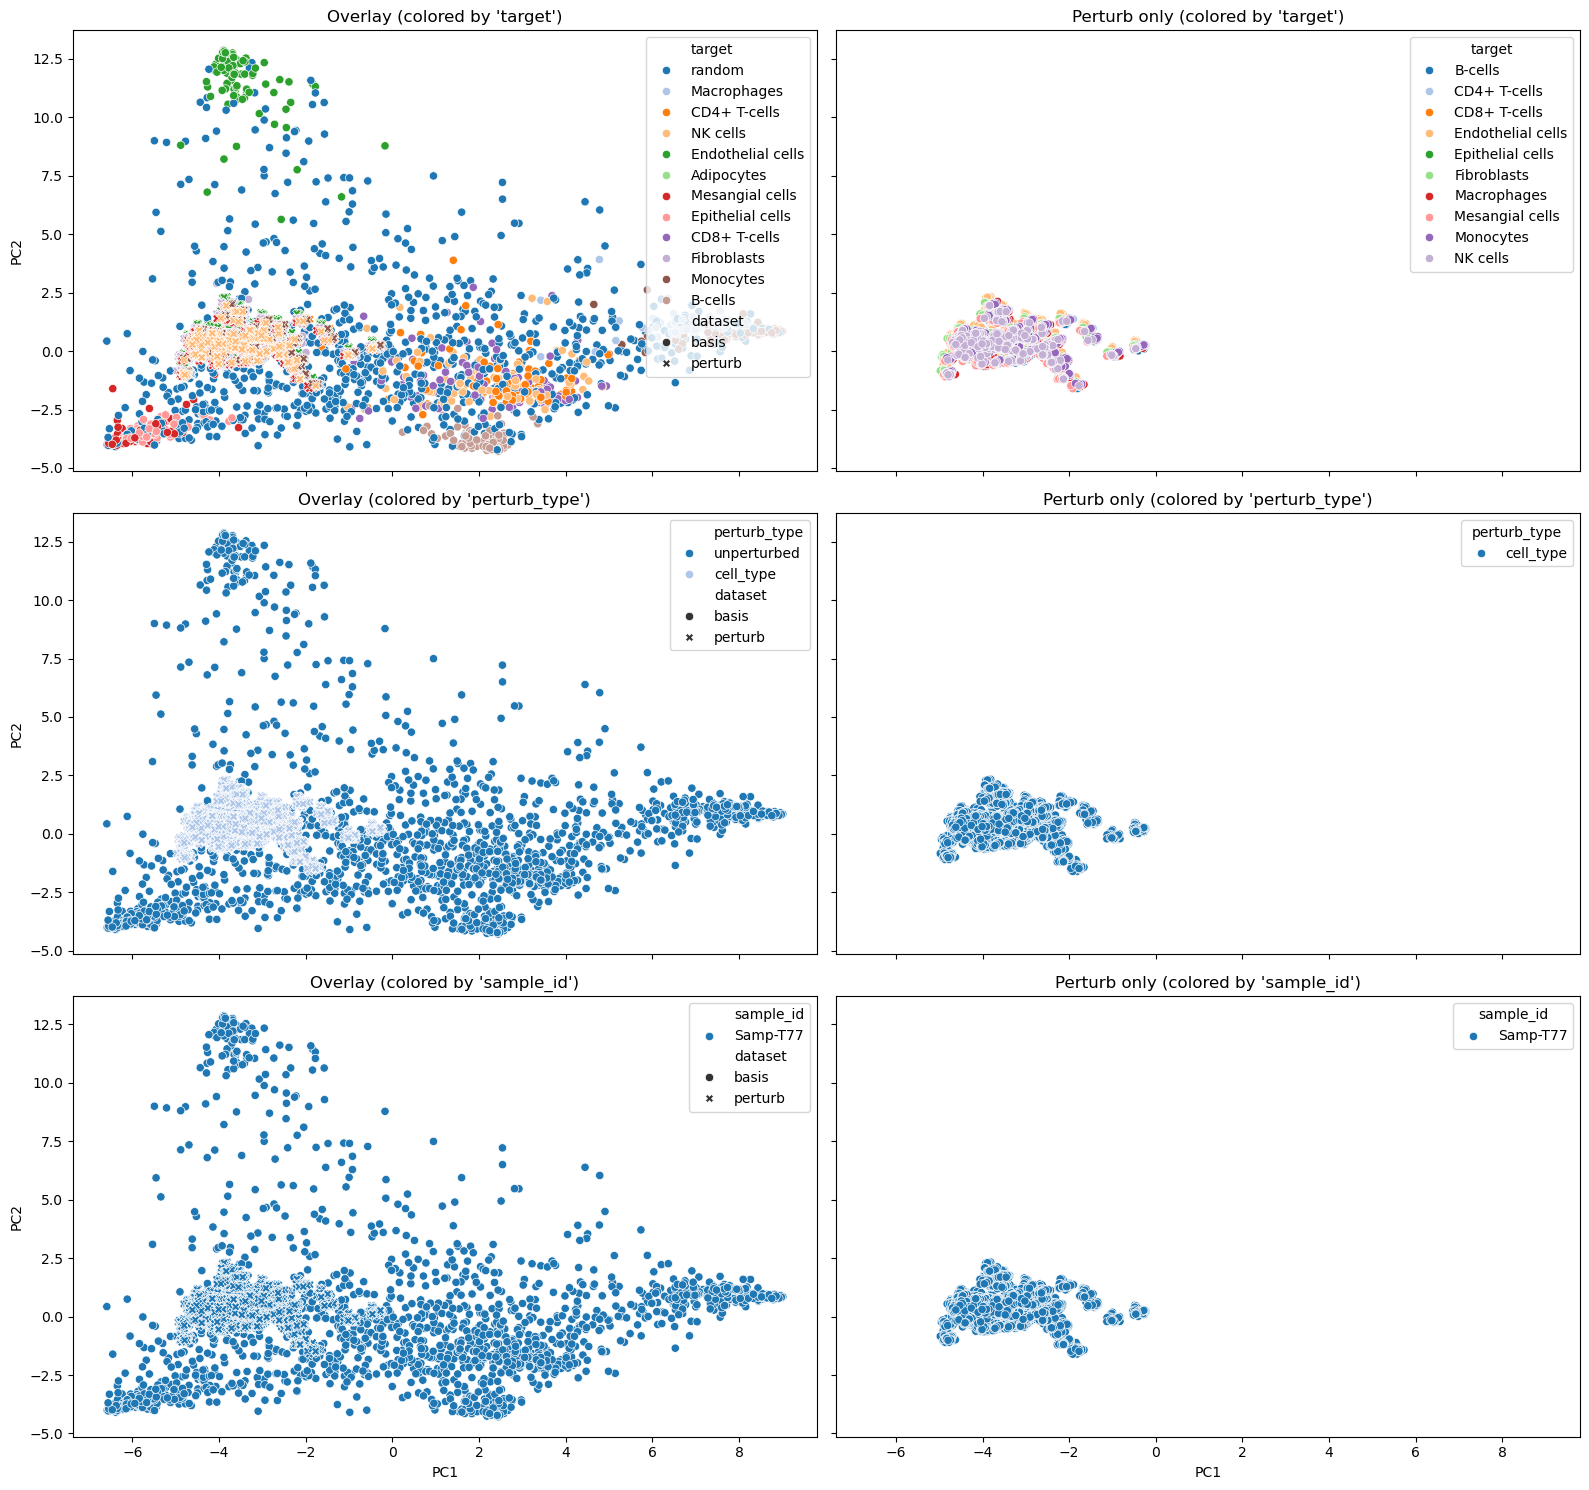

In [28]:
plot_perturb_pca(
    x_basis=x_reconstruct[np.where(train_data.get('kp', 'meta')['sample_id'] == 'Samp-T77')[0]],
    meta_basis=meta_reconstruct.iloc[np.where(train_data.get('kp', 'meta')['sample_id'] == 'Samp-T77')[0], :],
    x_perturb=x_perturb,
    meta_perturb=meta_perturb,
    filter_source='Adipocytes',
    filter_target=None,
    color_by=['sample_id'],
    pca_kwargs={'random_state': 0},
    figsize=(8, 5)
)